# Experimentation E-Commerce

### Import & Data Check

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.api as sms
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

%matplotlib inline

In [2]:
# Import dataset
df_raw = pd.read_csv("ab_data.csv")

# Print dataset
df_raw

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [3]:
# Print dF info
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


## Data Cleaning

In [4]:
# Check multiple values
multiple_sample = df_raw['user_id'].value_counts(ascending=False)
multiple = multiple_sample[multiple_sample > 1].count()

# Show how many multiple values in the dF
print(f'There are {multiple} users that appear multiple times in the data')

There are 3894 users that appear multiple times in the data


In [5]:
# The result will tell us that there are some control group that visiting the new page & vice versa
pd.crosstab(df_raw['group'], df_raw['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [6]:
# Removing multiple values in the data
drop_multiple = multiple_sample[multiple_sample > 1].index
df = df_raw[~df_raw['user_id'].isin(drop_multiple)]

# Show how many values will be used for the test
print(f'There are now {df.shape[0]} entries for the test')

There are now 286690 entries for the test


In [7]:
# Check values after dropping the multiple values
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 0 users that appear multiple times in the dataset


In [8]:
# The result will tell us that the control group are seeing only the old page & vice versa
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


## Determining the Number of Samples

In [9]:
# Calculate effect size
# - Hypothetical current CR = 18%
# - Hypothetical expected CR = 20%
effect = sms.proportion_effectsize(0.18, 0.20)

# Calculate required sample
n_sample = sms.NormalIndPower().solve_power(effect,
                                            power=0.8,
                                            alpha=0.05,
                                            ratio=1)

# Round the number up
n_sample = ceil(n_sample)

# Show how many required samples
print(n_sample)

6036


## Sampling

In [10]:
# Sampling to control group
# - Randomly sample n_sample number of data from control group
# - Set random seed to 6 for reproducibility
control_group = df[df['group'] == 'control'].sample(n=n_sample, random_state=6)

# Sampling to treatment group
# - Randomly sample n_sample number of data from treatment group
# - Set random seed to 6 for reproducibility
treatment_group = df[df['group'] == 'treatment'].sample(n=n_sample, random_state=6)

# A/B test dataframe
# - Concatenate control and treatment group samples into one dataframe
ab = pd.concat([control_group, treatment_group], axis=0)

# Reset index
# - Resets index to consecutive numbers
ab.reset_index(drop=True, inplace=True)

# Show result
ab

,user_id,timestamp,group,landing_page,converted
0,927583,2017-01-19 19:27:50.749807,control,old_page,0
1,844382,2017-01-03 10:31:08.462533,control,old_page,0
2,677439,2017-01-12 04:29:26.875140,control,old_page,0
3,630786,2017-01-22 03:15:20.594021,control,old_page,0
4,768826,2017-01-24 12:24:32.485732,control,old_page,0
...,...,...,...,...,...
12067,901906,2017-01-03 01:38:41.588713,treatment,new_page,0
12068,668695,2017-01-02 18:22:08.021072,treatment,new_page,0
12069,902403,2017-01-22 22:21:01.549027,treatment,new_page,0
12070,848269,2017-01-08 15:16:35.207407,treatment,new_page,1


In [11]:
# Check how many control and treatment group that are being sampled
# The result should be the same as the required samples which is 6036
ab['group'].value_counts()

control      6036
treatment    6036
Name: group, dtype: int64

## Statistics & Analysis

In [12]:
# Create conversion rate dF
cr = ab.groupby('group')['converted']

# Calculate standard deviation
std = lambda x: np.std(x, ddof=0)

# Calculate standard error mean
se = lambda x: stats.sem(x, ddof=0)

# Aggregate dF & show dF
cr = cr.agg([np.mean, std, se])
cr.columns = ['conversion_rate', 'standard_deviation', 'standard_error']
cr.style.format('{:.3f}')

,conversion_rate,standard_deviation,standard_error
group,,,
control,0.117,0.321,0.004
treatment,0.116,0.320,0.004


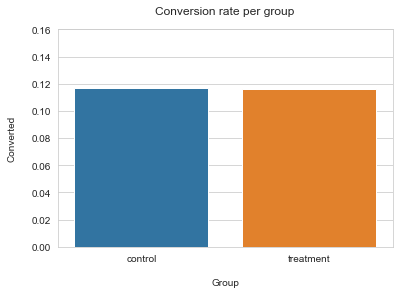

In [13]:
# Visualization
sns.set_style('whitegrid')
sns.barplot(x=ab['group'], y=ab['converted'], ci=False)

plt.ylim(0, 0.16)
plt.title("Conversion rate per group", pad=15)
plt.xlabel("Group", labelpad=15)
plt.ylabel("Converted", labelpad=15)
plt.show()

## Hypothesis Testing

In [14]:
# Filter the group
# Select control and treatment groups from ab dataframe
control_test = ab[ab['group'] == 'control']['converted']
treatment_test = ab[ab['group'] == 'treatment']['converted']

# Get the sample size of each group
n_control = control_test.count()
n_treatment = treatment_test.count()

# Calculate statistics for Z-score, P-value, and Confidence Interval
# Count the number of successes (converted) and number of trials (total number of samples) for each group
successes_probability = [control_test.sum(), treatment_test.sum()]
number_of_trials = [n_control, n_treatment]

# Calculate Z-score and P-value using the two-proportion z-test
z_stats, pvalue = proportions_ztest(successes_probability, nobs=number_of_trials)

# Calculate the confidence intervals for each group using the two-proportion z-test
(lower_control, lower_treatment), (upper_control, upper_treatment) = proportion_confint(successes_probability,
                                                                                        nobs=number_of_trials,
                                                                                        alpha=0.05)

# Print the results
print(f'Z-score (Standard Score): {z_stats:.2f}')
print(f'P-value: {pvalue:.3f}')
print(f'CI 95% (Control Group): [{lower_control:.3f}, {upper_control:.3f}]')
print(f'CI 95% for (Treatment Group): [{lower_treatment:.3f}, {upper_treatment:.3f}]')

# Interpret the results based on the p-value
if pvalue < 0.05:
    print("The null hypothesis is rejected")
else:
    print("The null hypothesis is accepted")

Z-score (Standard Score): 0.09
P-value: 0.932
CI 95% (Control Group): [0.109, 0.125]
CI 95% for (Treatment Group): [0.108, 0.124]
The null hypothesis is accepted
